Average Magnetization: 99.88235294117646 Average Energy: -199.52941176470588 Susceptibility: 0.0022145328719852843 Heat Capacity: 0.035432525951546265
Average Magnetization: 100.0 Average Energy: -200.0 Susceptibility: 0.0 Heat Capacity: 0.0
Average Magnetization: 99.49019607843137 Average Energy: -198.4313725490196 Susceptibility: 0.02463155196721042 Heat Capacity: 0.16156179247299302
Average Magnetization: 99.49019607843137 Average Energy: -198.11764705882354 Susceptibility: 0.01308372519446353 Heat Capacity: 0.1312558437924392
Average Magnetization: 99.37254901960785 Average Energy: -197.64705882352942 Susceptibility: 0.011753721096270703 Heat Capacity: 0.11581103029445268
Average Magnetization: 98.27450980392157 Average Energy: -193.80392156862746 Susceptibility: 0.02930155068561967 Heat Capacity: 0.2323345721730987
Average Magnetization: 98.43137254901961 Average Energy: -194.35294117647058 Susceptibility: 0.028738946559008115 Heat Capacity: 0.2112168396770356
Average Magnetizatio

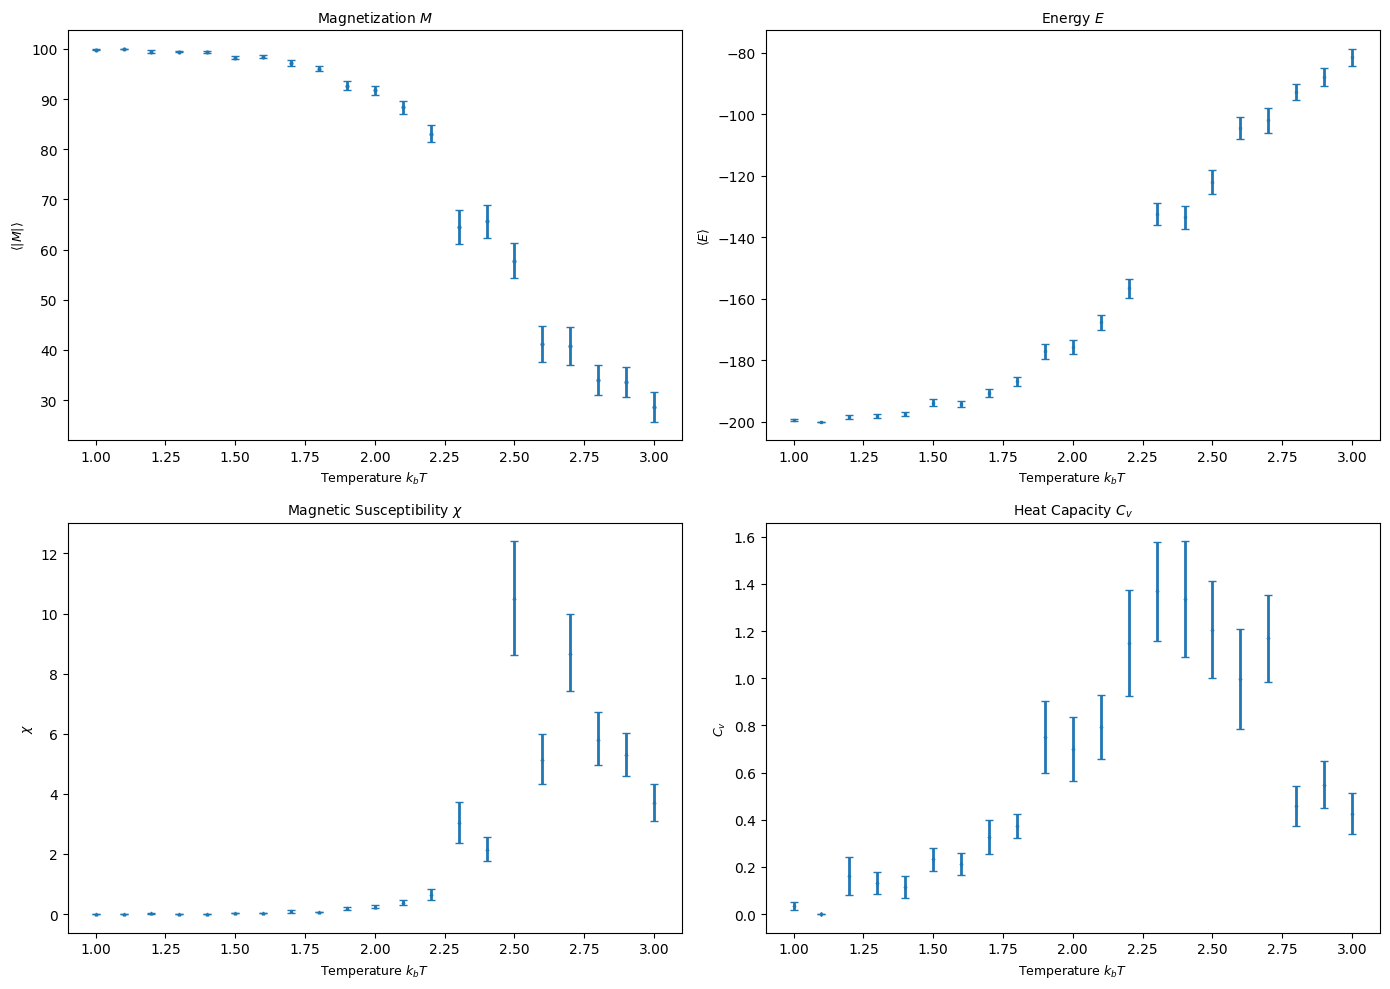

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from Lattice_Class import Lattice, Observables
import numpy as np
import json
import os

# -----------------------------
# Set parameters
# -----------------------------
size = 10
iteration = 500
sampling = 10
thermalisation = 100
algorithm = "glauber"
error_analysis = "bootstrap"
direction = "heating"
T_max = 3.0
T_min = 1.0
T_step = 0.1

# Output directory
output_dir = f"{algorithm}_{size}_{direction}"
os.makedirs(output_dir, exist_ok=True)

# Temperature values
if direction == 'cooling':
    T_vals = np.arange(T_max, T_min - T_step, -T_step)

elif direction == 'heating':
    T_vals = np.arange(T_min, T_max + T_step, T_step)

# -----------------------------
# Lists to store results
# -----------------------------
mag_list, mag_list_err = [], []
E_list, E_list_err = [], []
susceptibility_list, susceptibility_list_err = [], []
heat_capacity_list, heat_capacity_list_err = [], []

# -----------------------------
# Function to update lattice at each temperature
# -----------------------------
def update(T, old_grid, thermalisation):
    ising = Lattice(size=size, J=1, T=T, iterations=iteration,
                    algorithm=algorithm, thermalisation=thermalisation,
                    sampling=sampling, start_config=old_grid)
    
    list(ising.sim())  # Run the simulation
    new_grid = ising.grid

    # Compute observables
    Measurements = Observables(ising)
    Measurements.observables_with_errors(function=error_analysis)

    # Store results
    mag_list.append(Measurements.avg_mag)
    mag_list_err.append(Measurements.mag_error)
    E_list.append(Measurements.avg_E)
    E_list_err.append(Measurements.E_error)
    susceptibility_list.append(Measurements.susceptibility)
    susceptibility_list_err.append(Measurements.susceptibility_error)
    heat_capacity_list.append(Measurements.heat_capacity)
    heat_capacity_list_err.append(Measurements.heat_capacity_error)

    # Save individual temperature JSON
    data = {
        "T": float(T),
        "magnetisation": [float(x) for x in ising.magnetisation],
        "total_energy": [float(x) for x in ising.totenergy]
    }
    filename = os.path.join(output_dir, f"T_{T:.3f}.json")
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

    return new_grid

# -----------------------------
# Run simulation over temperatures and initialize with grid type
# -----------------------------
if algorithm == 'kawasaki':
    old_grid = np.random.choice([-1, 1], size=(size, size)) # For kawasaki, always start with a random configuration

elif algorithm == 'glauber':
    if direction == 'cooling':
        old_grid = np.random.choice([-1, 1], size=(size, size)) # random initial configuration for cooling
    elif direction == 'heating':
        old_grid = np.ones((size, size), dtype=int) # ordered spin configuration up for heating


old_grid = update(T_vals[0], old_grid, thermalisation * 5) # Extra thermalisation for first T
for T in T_vals[1:]:
    old_grid = update(T, old_grid, thermalisation)


# -----------------------------
# Save all observables in one JSON
# -----------------------------
results = {
    "T_vals": T_vals.tolist(),
    "parameters": {
        "size": size,
        "J": 1,
        "iterations": iteration,
        "algorithm": algorithm,
        "thermalisation": thermalisation,
        "sampling": sampling,
        "error_analysis": error_analysis
    },
    "magnetization": {"values": mag_list, "errors": mag_list_err},
    "energy": {"values": E_list, "errors": E_list_err},
    "susceptibility": {"values": susceptibility_list, "errors": susceptibility_list_err},
    "heat_capacity": {"values": heat_capacity_list, "errors": heat_capacity_list_err}
}

filename = os.path.join(output_dir, "Observables.json")
with open(filename, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {filename}")

plt.figure(figsize=(14, 10))

# Average Magnetization per spin
plt.subplot(2, 2, 1)
plt.errorbar(T_vals, mag_list, yerr=mag_list_err, fmt='o', markersize=2, elinewidth=2, capsize=3)
plt.title(r"Magnetization $M$", fontsize=10)
plt.xlabel(r"Temperature $k_bT$", fontsize=9)
plt.ylabel(r"$\langle |M| \rangle$", fontsize=9)

# Average Energy per spin
plt.subplot(2, 2, 2)
plt.errorbar(T_vals, E_list, yerr=E_list_err, fmt='s', markersize=2,
             elinewidth=2, capsize=3)
plt.title(r"Energy $E$", fontsize=10)
plt.xlabel(r"Temperature $k_bT$", fontsize=9)
plt.ylabel(r"$\langle E \rangle$", fontsize=9)

# Susceptibility
plt.subplot(2, 2, 3)
plt.errorbar(T_vals, susceptibility_list, yerr=susceptibility_list_err, fmt='^', markersize=2,
             elinewidth=2, capsize=3)
plt.title(r"Magnetic Susceptibility $\chi$", fontsize=10)
plt.xlabel(r"Temperature $k_bT$", fontsize=9)
plt.ylabel(r"$\chi$", fontsize=9)

# Heat Capacity
plt.subplot(2, 2, 4)
plt.errorbar(T_vals, heat_capacity_list, yerr=heat_capacity_list_err, fmt='d', markersize=2,
             elinewidth=2, capsize=3)
plt.title(r"Heat Capacity $C_v$", fontsize=10)
plt.xlabel(r"Temperature $k_bT$", fontsize=9)
plt.ylabel(r"$C_v$", fontsize=9)

plt.tight_layout()
plt.show()